In [3]:
# install.packages("repr")

library(repr)

# install.packages("ggplot2")

library(ggplot2)

# install.packages("dplyr")
library(dplyr)

# library(dplyr)

# install.packages("reshape")
# library(reshape)

library(reshape)

# install.packages('survival')

library(survival)

# install.packages('zoo')

library(zoo)

[1] "cox_eICU_loss_v3_parameter_VARwt_200904.ipynb"
[2] "data"                                         
[3] "Dockerfile"                                   
[4] "functions.R"                                  
[5] "Untitled Folder"                              
[6] "utils.R"                                      
[7] "WIM.ipynb"                                    
[8] "wim.R"

In [8]:
total <- read.csv("data/total_logistic.csv", header = TRUE, sep = ",")
central <- filter(total, hospitalid==420 | hospitalid==443 | hospitalid==199 | hospitalid==449 | hospitalid==416 
                 | hospitalid==394 | hospitalid==79 | hospitalid==183 | hospitalid==181 | hospitalid==184)

central <- rename(central,
                  c(actualiculos="time",
                    mortality2="Y",
                    age="x1",
                    GCS2="x2",
                    temperature2="x3",
                    ph2="x4",
                    pco22="x5",
                    bun2="x6",
                    bilirubin2="x7",
                    fio22="x8"
                  ))


central <- select(central, hospitalid, time, Y, x1, x2, x3, x4, x5, x6, x7, x8)
central <- na.omit(central)
table(distinct(central, hospitalid, .keep_all=TRUE)$hospitalid)
#ls.str(central)

central <- filter(central, time<=50)
#----------- 기관 데이터 분할
H1 <- filter(central, hospitalid==420)
H2 <- filter(central, hospitalid==443)
H3 <- filter(central, hospitalid==199)
H4 <- filter(central, hospitalid==449)
H5 <- filter(central, hospitalid==416)
H6 <- filter(central, hospitalid==394)
H7 <- filter(central, hospitalid==79 )
H8 <- filter(central, hospitalid==183)
H9 <- filter(central, hospitalid==181)
H10 <- filter(central, hospitalid==184)


 79 181 183 184 199 394 416 420 443 449 
  1   1   1   1   1   1   1   1   1   1 

In [12]:
# 𝑝p 
# In [ ]:
#=============================================================
# parameter setting
#=============================================================
party <- 10
n_H <- 10
for(i in 1:party){
  assign(paste0('H',i,'_Y0'), filter(get(paste0('H',i)), Y==0))
  assign(paste0('H',i,'_Y1'), filter(get(paste0('H',i)), Y==1))
  
  assign(paste0('H',i,'_n'), nrow(get(paste0('H',i))))
  assign(paste0('H',i,'_n1'), ceiling(((nrow(get(paste0('H',i))))*2)/3))
  
  assign(paste0('H',i,'_Y0_n'), nrow(get(paste0('H',i,'_Y0'))))
  assign(paste0('H',i,'_Y0_n1'), ceiling(((nrow(get(paste0('H',i,'_Y0'))))*2)/3))
  
  assign(paste0('H',i,'_Y1_n'), nrow(get(paste0('H',i,'_Y1'))))
  assign(paste0('H',i,'_Y1_n1'), ceiling(((nrow(get(paste0('H',i,'_Y1'))))*2)/3))
}

R <- 200
x <- 8

In [13]:
#=================================================================================================
# generating Z(1) and Z(2) 
#=================================================================================================

set.seed(1)
for(H in 1:party){
  for(i in 1:R){
    #--Y=0
    idx <- sample(1:nrow(get(paste0('H',H,'_Y0'))), nrow(get(paste0('H',H,'_Y0'))), replace = FALSE)
    assign(paste0('H',H,'_Y0_2'), get(paste0('H',H,'_Y0'))[idx,]) 
    assign(paste0('R1_H',H,'_Y0_',i), get(paste0('H',H,'_Y0_2'))[1:get(paste0('H',H,'_Y0_n1')), ])  # 모델 ?????? Z(1)
    assign(paste0('R2_H',H,'_Y0_',i), get(paste0('H',H,'_Y0_2'))[(get(paste0('H',H,'_Y0_n1'))+1):nrow(get(paste0('H',H,'_Y0'))), ])  # 모델 검??? Z(2)
    #  remove(get(paste0('H',H,'_Y0_2')))
    
    #--Y=1
    idx <- sample(1:nrow(get(paste0('H',H,'_Y1'))), nrow(get(paste0('H',H,'_Y1'))), replace = FALSE)
    assign(paste0('H',H,'_Y1_2'), get(paste0('H',H,'_Y1'))[idx,]) 
    assign(paste0('R1_H',H,'_Y1_',i), get(paste0('H',H,'_Y1_2'))[1:get(paste0('H',H,'_Y1_n1')), ])  # 모델 ?????? Z(1)
    assign(paste0('R2_H',H,'_Y1_',i), get(paste0('H',H,'_Y1_2'))[(get(paste0('H',H,'_Y1_n1'))+1):nrow(get(paste0('H',H,'_Y1'))), ])  # 모델 검??? Z(2)
    #  remove(get(paste0('H',H,'_Y1_2')))
    
    #-- Y=0 + Y=1
    assign(paste0('R1_H',H,'_',i), rbind(get(paste0('R1_H',H,'_Y0_',i)), get(paste0('R1_H',H,'_Y1_',i)) ) ) # Z(1)
    assign(paste0('R2_H',H,'_',i), rbind(get(paste0('R2_H',H,'_Y0_',i)), get(paste0('R2_H',H,'_Y1_',i)) ) ) # Z(2)
  }
}

In [22]:
H1_Y0
R2_H1_Y0_1

hospitalid,time,Y,x1,x2,x3,x4,x5,x6,x7,x8
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
420,25.0208,0,46,10,39.6,7.37,42,35,1.3,50
420,18.0208,0,62,9,32.2,7.31,40,32,0.3,70
420,4.2256,0,63,13,36.3,7.43,62,13,0.3,70
420,9.4548,0,71,6,36.5,7.30,69,39,1.5,100
420,44.4562,0,24,7,36.0,7.24,44,11,0.6,60
420,13.9409,0,67,4,36.2,7.50,26,48,6.3,60
420,2.0263,0,83,13,36.9,7.44,42,39,0.9,28
420,6.9861,0,78,13,37.8,7.41,44,63,0.2,100
420,12.0375,0,65,12,36.0,7.31,44,51,0.4,28


,hospitalid,time,Y,x1,x2,x3,x4,x5,x6,x7,x8
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55,420,1.4965,0,67,15,36.2,7.26,28,17,1.2,40
69,420,1.4513,0,62,11,37.0,7.35,36,23,5.7,40
275,420,4.6833,0,58,6,36.2,7.18,49,17,0.5,60
158,420,2.8715,0,89,3,36.0,7.38,28,79,0.9,50
309,420,34.5145,0,41,7,36.1,7.27,43,18,0.7,100
286,420,27.7708,0,50,5,36.1,7.25,53,9,0.3,75
306,420,5.4798,0,43,7,37.0,7.24,53,27,0.9,35
81,420,6.1006,0,50,9,36.5,7.25,63,18,0.2,60
295,420,2.6597,0,76,15,37.5,7.44,36,16,1.0,100


In [16]:
total

hospitalid,numbedscategory,patientunitstayid,gender,ethnicity,acutephysiologyscore,apachescore,apacheversion,actualicumortality,actualiculos,⋯,albumin2,pao22,pco22,bun2,glucose2,bilirubin2,fio22,mortality2,feature27_aids,feature27
<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
56,<100,141557,Female,Caucasian,49,66,IVa,ALIVE,1.2812,⋯,NA,NA,NA,84,104,NA,NA,0,NA,NA
56,<100,141822,Male,Caucasian,47,76,IVa,ALIVE,1.8416,⋯,2.3,NA,NA,8,147,0.5,NA,0,NA,NA
56,<100,142209,Female,Caucasian,57,73,IVa,ALIVE,4.1340,⋯,NA,66,28,31,367,NA,30,0,NA,NA
56,<100,143493,Male,Caucasian,-1,-1,IVa,ALIVE,0.1743,⋯,2.5,NA,NA,9,166,1.3,NA,0,NA,NA
56,<100,143633,Female,Caucasian,53,77,IVa,ALIVE,1.6590,⋯,2.4,NA,NA,45,167,0.2,NA,0,NA,NA
56,<100,143920,Male,Caucasian,30,35,IVa,ALIVE,0.7006,⋯,2.8,NA,NA,8,217,0.4,NA,0,NA,NA
56,<100,143928,Female,Caucasian,52,69,IVa,ALIVE,4.7548,⋯,1.9,NA,NA,11,76,1.0,NA,0,NA,NA
56,<100,144815,Female,Caucasian,25,25,IVa,ALIVE,0.7784,⋯,3.6,NA,NA,6,82,0.5,NA,0,NA,NA
56,<100,145030,Female,Caucasian,30,35,IVa,ALIVE,1.0708,⋯,3.8,NA,NA,8,189,0.6,NA,0,NA,NA


In [37]:
m <- matrix(nrow=2,ncol=3)

In [40]:
m[1,2]

[1] NA

In [51]:
#=================================================================================================
# Hospital 1, 2, 3 Model from Z(1)'s
#=================================================================================================
#===============Coefficient's
x<-8
for(H in 1:party){
  for(i in 1:R){
    assign( paste0('total_model',H), matrix(nrow=R, ncol=(x*2)) )
    assign(paste0('cox_H',H, "_", i), coxph(Surv(time, Y)~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                                            data=get(paste0('R1_H',H, "_",i)), ties="breslow"))
    #    assign(paste0('base_cox_H',H,'_',i), basehaz(coxph(Surv(time, Y)~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11, 
    #                                                       data=get(paste0('R1_H',H, "_",i)), ties="breslow"), centered=FALSE))
    }

  
  assign.by.char <- function(x,  ...) {
    eval.parent(assign(x,  do.call(`[<-`, list(get(x) , ...)))) }
  #-------
  for(i in 1:R){
    for(j in 1:x){
      a <- assign.by.char(paste0('total_model',H),i,j,get(paste0('cox_H',H,'_',i))$coefficients[j] )
      assign(paste0('total_model',H), a)

      a <- assign.by.char(paste0('total_model',H),i,(j+8), summary(get(paste0('cox_H',H,'_',i)))$coefficients[j,3] )
      assign(paste0('total_model',H), a)
            #  get(paste0('total_model',H))[i,1:x] <- get(paste0('cox_H',H,'_',i))$coefficients[1:x]   
    }
}
}   

In [48]:
cox_H1_1

Call:
coxph(formula = Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + 
    x7 + x8, data = get(paste0("R1_H", H, "_", i)), ties = "breslow")

        coef exp(coef)  se(coef)      z        p
x1  0.014497  1.014603  0.008275  1.752  0.07980
x2 -0.143886  0.865987  0.034493 -4.171 3.03e-05
x3 -0.105317  0.900039  0.060511 -1.740  0.08178
x4 -3.339738  0.035446  1.018500 -3.279  0.00104
x5 -0.014317  0.985785  0.011689 -1.225  0.22064
x6  0.007882  1.007913  0.004368  1.805  0.07114
x7  0.037753  1.038474  0.029006  1.302  0.19307
x8  0.005665  1.005681  0.004712  1.202  0.22928

Likelihood ratio test=82.53  on 8 df, p=1.513e-14
n= 353, number of events= 98 

In [49]:
a %>% dim

[1] 200  16

In [50]:
total_model1

NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [17]:
  assign(paste0('total_model', H), rename(data.frame(get(paste0('total_model',H))),
                                          c(X1="x1",
                                            X2="x2",
                                            X3="x3",
                                            X4="x4",
                                            X5="x5",
                                            X6="x6",
                                            X7="x7",
                                            X8="x8",
                                            X9="x1_se",
                                            X10="x2_se",
                                            X11="x3_se",
                                            X12="x4_se",
                                            X13="x5_se",
                                            X14="x6_se",
                                            X15="x7_se",
                                            X16="x8_se"
                                          ) ) )
}  

for(H in 1:party){
  event <- select(filter(get(paste0("H",H)), Y==1), time)
  grouped <- group_by(event, time)
  assign(paste0("H",H,"_time"), summarise(grouped, n_event=n()  ) )
}
#View(H1_time)

In [ ]:
# eval.parent는 전역변수를 부르는 함수.

In [28]:
eval.parent(assign("exp", do.call(`[<-`, list(get(x) , ...))))

ERROR: Error in get(x): 첫번째 인자가 유효하지 않습니다


In [31]:
x <- list(c(1,2,3),c(4,5,6))
lapply(x,rbind)
do.call(rbind,x)

1,2,3
4,5,6


1,2,3
4,5,6


In [19]:
total_model1

x1,x2,x3,x4,x5,x6,x7,x8,x1_se,x2_se,x3_se,x4_se,x5_se,x6_se,x7_se,x8_se
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01449715,-0.14388568,-0.1053167,-3.339738,-0.0143174479,0.0078815952,0.037752703,0.0056649158,0.008275370,0.03449265,0.06051106,1.0184995,0.011689425,0.004367615,0.02900576,0.004712072
0.01739283,-0.13362208,-0.2393389,-4.821149,-0.0092808885,0.0048629673,0.017515568,-0.0007369095,0.007509347,0.03579527,0.06002607,0.8978899,0.009571506,0.003822059,0.01788307,0.004771950
0.01650187,-0.12393858,-0.1096681,-3.879364,-0.0059391349,-0.0002930863,0.056196566,0.0107719862,0.007792345,0.03439977,0.06166121,0.9823348,0.010830044,0.004881283,0.02908058,0.004787191
0.03106854,-0.10460354,-0.2735646,-3.301282,-0.0078437990,0.0053419450,0.028873608,0.0072231643,0.007901541,0.03170324,0.05773440,0.8660750,0.009728117,0.003821896,0.01635766,0.004630104
0.01835501,-0.11461972,-0.1186429,-4.304465,-0.0104957300,-0.0013516901,0.006082017,0.0061715421,0.008100960,0.03289360,0.05661673,0.8860620,0.010041779,0.004784036,0.02283008,0.004650418
0.01210450,-0.09755367,-0.1837539,-3.731396,-0.0091016005,0.0032538262,0.024854173,0.0048089341,0.007515590,0.03290925,0.05802333,0.9836058,0.010853971,0.004119963,0.01492670,0.004861922
0.01935279,-0.08923203,-0.3653200,-3.979777,0.0059500522,0.0015662764,0.008819252,0.0060090358,0.007338776,0.03214995,0.06793683,0.9699850,0.009300898,0.004215367,0.02281894,0.004643298
0.01677526,-0.10131722,-0.2093440,-3.444323,-0.0060655334,0.0069118801,0.011360694,0.0041650841,0.007717999,0.03400212,0.05776596,0.9335142,0.010559670,0.003994760,0.02098443,0.004743025
0.01204423,-0.10645806,-0.1571032,-3.759076,-0.0048360466,0.0119259188,0.014735206,0.0051005187,0.007591606,0.03290514,0.05503312,1.0325516,0.010794704,0.004803784,0.01657425,0.004737477


In [ ]:
#=================================================================================================
# Hospital  Z(2) ??? 3 모델 fitting
#=================================================================================================

for(H in 1:party){
  
  #------------ H1-Z(2) ??? ?????? Hospital 1,2,3 모델??? survival prob
  for(i in 1:R){
    assign(paste0('likeli_H',H,'_',i) , matrix(nrow=nrow(get(paste0('R2_H',H,'_',i))), ncol=(n_H*2+2) )) 
    matrix_name <- paste0('likeli_H',H,'_', i) 
    for(n in 1:nrow(get(paste0('likeli_H',H,'_',i)))){
      for( model in 1:party){
        
        #-- Likelihood
        exp_lp <- exp( get(paste0('R2_H',H,'_',i))$x1[n]*get(paste0('total_model',model))$x1[i] + 
                         get(paste0('R2_H',H,'_',i))$x2[n]*get(paste0('total_model',model))$x2[i] +
                         get(paste0('R2_H',H,'_',i))$x3[n]*get(paste0('total_model',model))$x3[i] +
                         get(paste0('R2_H',H,'_',i))$x4[n]*get(paste0('total_model',model))$x4[i] +
                         get(paste0('R2_H',H,'_',i))$x5[n]*get(paste0('total_model',model))$x5[i] +
                         get(paste0('R2_H',H,'_',i))$x6[n]*get(paste0('total_model',model))$x6[i] +
                         get(paste0('R2_H',H,'_',i))$x7[n]*get(paste0('total_model',model))$x7[i] +
                         get(paste0('R2_H',H,'_',i))$x8[n]*get(paste0('total_model',model))$x8[i]  )
        
        a <- assign.by.char(matrix_name, n, model, as.numeric(exp_lp) )
        assign(matrix_name, a) 
        
        b <- assign.by.char(matrix_name, n, model+n_H, as.numeric(log(exp_lp) ))
        assign(matrix_name, b) 
        #      H_t <- get(paste0('total_model',model))[i,(x+t)]*exp_lp
        #      a <- assign.by.char(matrix_name, n, (t+S*(model-1)), exp(-H_t) )
        #      assign(matrix_name, a) 
        
        
        #--- time, event 
        a1 <- assign.by.char(matrix_name, n, n_H*2+1, get(paste0('R2_H',H,'_',i))$Y[n]) #- Event
        assign(matrix_name, a1)
        a2 <- assign.by.char(matrix_name, n, n_H*2+2, get(paste0('R2_H',H,'_',i))$time[n]) #- time
        assign(matrix_name, a2)
        #      assign(matrix_name, a3)
        #      a4 <- assign.by.char(matrix_name, n, n_H+4, paste0('H',H)) #- time2
        #      assign(matrix_name, a4)
        
      }
    }

    assign(paste0('likeli_H',H,'_',i), rename(data.frame(get(paste0('likeli_H',H,'_',i))),
                                              c(X1="model1_exp_lp",
                                                X2="model2_exp_lp",
                                                X3="model3_exp_lp",
                                                X4="model4_exp_lp",
                                                X5="model5_exp_lp",
                                                X6="model6_exp_lp",
                                                X7="model7_exp_lp",
                                                X8="model8_exp_lp",
                                                X9="model9_exp_lp",
                                                X10="model10_exp_lp",
                                                
                                                X11="model1_log_lp",
                                                X12="model2_log_lp",
                                                X13="model3_log_lp",
                                                X14="model4_log_lp",
                                                X15="model5_log_lp",
                                                X16="model6_log_lp",
                                                X17="model7_log_lp",
                                                X18="model8_log_lp",
                                                X19="model9_log_lp",
                                                X20="model10_log_lp",
                                                X21="Y",
                                                X22="time"
                                                #                                                X9="time2"
                                                #                                            X7="hos"
                                                
                                              ) ) )
    assign(paste0('likeli_H',H,'_',i), arrange(get(paste0('likeli_H',H,'_',i)), by=time) ) # sorting by time2
    
  }
}
#View(likeli_H1_5)

#----------------------------------------------------------------------------
assign.by.char <- function(x,  ...) {
  eval.parent(assign(x,  do.call(`[<-`, list(get(x) , ...)))) }

#-----------------------------------------------------------------------------
for(H in 1:n_H){
  for(m in 1:R){
    assign(paste0('L_sum_H',H,'_',m) , matrix(nrow=nrow(get(paste0("likeli_H",H,"_",m))), ncol=n_H) ) 
    matrix_name <- paste0('L_sum_H',H,'_',m)
    #  model1 <- get(paste0("likeli_total_m",m))[,1]
    model1 <- get(paste0("likeli_H",H,"_",m))$model1_exp_lp
    model2 <- get(paste0("likeli_H",H,"_",m))$model2_exp_lp
    model3 <- get(paste0("likeli_H",H,"_",m))$model3_exp_lp
    model4 <- get(paste0("likeli_H",H,"_",m))$model4_exp_lp
    model5 <- get(paste0("likeli_H",H,"_",m))$model5_exp_lp
    model6 <- get(paste0("likeli_H",H,"_",m))$model6_exp_lp
    model7 <- get(paste0("likeli_H",H,"_",m))$model7_exp_lp
    model8 <- get(paste0("likeli_H",H,"_",m))$model8_exp_lp
    model9 <- get(paste0("likeli_H",H,"_",m))$model9_exp_lp
    model10 <- get(paste0("likeli_H",H,"_",m))$model10_exp_lp
    
    for(i in 1:nrow(get(paste0("likeli_H",H,"_",m)))){
      a1 <- assign.by.char(matrix_name, i, 1, as.numeric(log(sum(model1[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) ) 
      assign(matrix_name, a1)
      a2 <- assign.by.char(matrix_name, i, 2, as.numeric(log(sum(model2[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a2)
      a3 <- assign.by.char(matrix_name, i, 3, as.numeric(log(sum(model3[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a3)
      a4 <- assign.by.char(matrix_name, i, 4, as.numeric(log(sum(model4[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a4)
      a5 <- assign.by.char(matrix_name, i, 5, as.numeric(log(sum(model5[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a5)
      a6 <- assign.by.char(matrix_name, i, 6, as.numeric(log(sum(model6[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a6)
      a7 <- assign.by.char(matrix_name, i, 7, as.numeric(log(sum(model7[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a7)
      a8 <- assign.by.char(matrix_name, i, 8, as.numeric(log(sum(model8[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a8)
      a9 <- assign.by.char(matrix_name, i, 9, as.numeric(log(sum(model9[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a9)
      a10 <- assign.by.char(matrix_name, i, 10, as.numeric(log(sum(model10[i:nrow(get(paste0("likeli_H",H,"_",m)))]))) )
      assign(matrix_name, a10)
      
      
          } 
    assign(paste0('L_sum_H',H,'_',m), rename(data.frame(get(paste0('L_sum_H',H,'_',m))),
                                             c(X1="model1_log_L_sum",
                                               X2="model2_log_L_sum",
                                               X3="model3_log_L_sum",
                                               X4="model4_log_L_sum",
                                               X5="model5_log_L_sum",
                                               X6="model6_log_L_sum",
                                               X7="model7_log_L_sum",
                                               X8="model8_log_L_sum",
                                               X9="model9_log_L_sum",
                                               X10="model10_log_L_sum"
                                             ) ) )
  }
  for(m in 1:R){
    #---- log_L_sum add
    assign(paste0("L_sum2_H",H,"_",m), select(cbind(get(paste0("likeli_H",H,"_",m)), get(paste0("L_sum_H",H,"_",m))),
                                              time, model1_log_L_sum, model2_log_L_sum, model3_log_L_sum,model4_log_L_sum,
                                              model5_log_L_sum,model6_log_L_sum,model7_log_L_sum,model8_log_L_sum,
                                              model9_log_L_sum, model10_log_L_sum) )
    #---- ?????? time ?????? L_sum
    assign(paste0("L_sum3_H",H,"_",m), distinct(get(paste0("L_sum2_H",H,"_",m)), time, .keep_all=TRUE) )
    assign(paste0("likeli2_H",H,"_",m), 
           inner_join(get(paste0("likeli_H",H,"_",m)),get(paste0("L_sum3_H",H,"_",m)), by="time") )
  }
} 
#View(likeli2_H10_1)
#nrow(L_sum3_H1_1)


#======================Calculate final likelihood in each hospital
H1_loss <- matrix(nrow=R, ncol=n_H)
H2_loss <- matrix(nrow=R, ncol=n_H)
H3_loss <- matrix(nrow=R, ncol=n_H)
H4_loss <- matrix(nrow=R, ncol=n_H)
H5_loss <- matrix(nrow=R, ncol=n_H)
H6_loss <- matrix(nrow=R, ncol=n_H)
H7_loss <- matrix(nrow=R, ncol=n_H)
H8_loss <- matrix(nrow=R, ncol=n_H)
H9_loss <- matrix(nrow=R, ncol=n_H)
H10_loss <- matrix(nrow=R, ncol=n_H)

#H1_z2 <- 47
#H2_z2 <- 25
#H3_z2 <- 17
#View(likeli2_H1_1)
#View(matrix_name)
for(H in 1:n_H){
  for(m in 1:R){
    matrix_name <- filter(get(paste0("likeli2_H",H,"_",m)), Y==1) 
    
    model1_log_L_sum <- matrix_name$model1_log_L_sum
    model1_log_lp <- matrix_name$model1_log_lp
    model2_log_L_sum <- matrix_name$model2_log_L_sum
    model2_log_lp <- matrix_name$model2_log_lp
    model3_log_L_sum <- matrix_name$model3_log_L_sum
    model3_log_lp <- matrix_name$model3_log_lp
    model4_log_L_sum <- matrix_name$model4_log_L_sum
    model4_log_lp <- matrix_name$model4_log_lp
    model5_log_L_sum <- matrix_name$model5_log_L_sum
    model5_log_lp <- matrix_name$model5_log_lp
    model6_log_L_sum <- matrix_name$model6_log_L_sum
    model6_log_lp <- matrix_name$model6_log_lp
    model7_log_L_sum <- matrix_name$model7_log_L_sum
    model7_log_lp <- matrix_name$model7_log_lp
    model8_log_L_sum <- matrix_name$model8_log_L_sum
    model8_log_lp <- matrix_name$model8_log_lp
    model9_log_L_sum <- matrix_name$model9_log_L_sum
    model9_log_lp <- matrix_name$model9_log_lp
    model10_log_L_sum <- matrix_name$model10_log_L_sum
    model10_log_lp <- matrix_name$model10_log_lp
    
    model1_loss <- sum(model1_log_L_sum - model1_log_lp)
    model2_loss <- sum(model2_log_L_sum - model2_log_lp)
    model3_loss <- sum(model3_log_L_sum - model3_log_lp)
    model4_loss <- sum(model4_log_L_sum - model4_log_lp)
    model5_loss <- sum(model5_log_L_sum - model5_log_lp)
    model6_loss <- sum(model6_log_L_sum - model6_log_lp)
    model7_loss <- sum(model7_log_L_sum - model7_log_lp)
    model8_loss <- sum(model8_log_L_sum - model8_log_lp)
    model9_loss <- sum(model9_log_L_sum - model9_log_lp)
    model10_loss <- sum(model10_log_L_sum - model10_log_lp)

    #model1_loss <- sum(model1_log_L_sum - model1_log_lp) / get(paste0("H",H,"_z2"))
    #model2_loss <- sum(model2_log_L_sum - model2_log_lp) / get(paste0("H",H,"_z2"))
    #model3_loss <- sum(model3_log_L_sum - model3_log_lp) / get(paste0("H",H,"_z2"))
    
    matrix_loss <- paste0("H",H,"_loss")
    
    model1 <- assign.by.char(matrix_loss, m, 1, model1_loss)
    assign(matrix_loss, model1)
    model2 <- assign.by.char(matrix_loss, m, 2, model2_loss)
    assign(matrix_loss, model2)
    model3 <- assign.by.char(matrix_loss, m, 3, model3_loss)
    assign(matrix_loss, model3)
    model4 <- assign.by.char(matrix_loss, m, 4, model4_loss)
    assign(matrix_loss, model4)
    model5 <- assign.by.char(matrix_loss, m, 5, model5_loss)
    assign(matrix_loss, model5)
    model6 <- assign.by.char(matrix_loss, m, 6, model6_loss)
    assign(matrix_loss, model6)
    model7 <- assign.by.char(matrix_loss, m, 7, model7_loss)
    assign(matrix_loss, model7)
    model8 <- assign.by.char(matrix_loss, m, 8, model8_loss)
    assign(matrix_loss, model8)
    model9 <- assign.by.char(matrix_loss, m, 9, model9_loss)
    assign(matrix_loss, model9)
    model10 <- assign.by.char(matrix_loss, m, 10, model10_loss)
    assign(matrix_loss, model10)
  }
}

#View(H1_loss)

In [15]:
#======================================================================
# Integrate loss from each hospital in local site
#======================================================================

#--------- loss sum
total_loss <- matrix(nrow=R, ncol=n_H)
for(i in 1:n_H){
  for(m in 1:R){
    total_loss[m,i] <- H1_loss[m,i] + H2_loss[m,i] + H3_loss[m,i] + H4_loss[m,i] + H5_loss[m,i] +
      H6_loss[m,i] + H7_loss[m,i] + H8_loss[m,i] + H9_loss[m,i] + H10_loss[m,i]
  }
}
#qView(total_loss)
#for(H in 1:10){
#write.csv(get(paste0("H",H, "_loss")), paste0("eICU_cox_feature8_ori_H",H,"_loss.csv"))
#}
#write.csv(total_loss, "eICU_cox_feature8_ori_total_loss.csv")

#---------- final 200 weights
loss_weight <- matrix(ncol=(n_H), nrow=R)
for(m in 1:R){ 
  total <- ((1/total_loss[m,1]) + (1/total_loss[m,2]) + (1/total_loss[m,3]) + (1/total_loss[m,4]) +
    (1/total_loss[m,5]) + (1/total_loss[m,6]) + (1/total_loss[m,7]) + (1/total_loss[m,8]) + (1/total_loss[m,9]) + (1/total_loss[m,10]) )
    loss_weight[m,1] <- (1/total_loss[m,1])/total
    
  loss_weight[m,2] <- (1/total_loss[m,2])/total
  loss_weight[m,3] <- (1/total_loss[m,3])/total
  loss_weight[m,4] <- (1/total_loss[m,4])/total
  loss_weight[m,5] <- (1/total_loss[m,5])/total
  loss_weight[m,6] <- (1/total_loss[m,6])/total
  loss_weight[m,7] <- (1/total_loss[m,7])/total
  loss_weight[m,8] <- (1/total_loss[m,8])/total
  loss_weight[m,9] <- (1/total_loss[m,9])/total
  loss_weight[m,10] <- (1/total_loss[m,10])/total

}

x <- 8
for(j in 1:x){
assign(paste0("loss_weight_x",j) , matrix(ncol=(n_H), nrow=R) )
}
for(m in 1:R){
  for(i in 1:x){
    total <- 1/(total_model1[m,(x+i)]^2) +
             1/(total_model2[m,(x+i)]^2) +
             1/(total_model3[m,(x+i)]^2) +
             1/(total_model4[m,(x+i)]^2) +
             1/(total_model5[m,(x+i)]^2) +
             1/(total_model6[m,(x+i)]^2) +
             1/(total_model7[m,(x+i)]^2) +
             1/(total_model8[m,(x+i)]^2) +
             1/(total_model9[m,(x+i)]^2) +
             1/(total_model10[m,(x+i)]^2) 
  for(H in 1:n_H){ 
    matrix_name <- paste0("loss_weight_x",i)
    a <- assign.by.char(matrix_name, m, H, 
                        (1/(get(paste0("total_model",H))[m,(x+i)]^2) )/ total ) 
    assign(matrix_name, a) 
  }
  }
}

for(j in 1:x){
  assign(paste0("loss_VARwt_x",j) , matrix(ncol=(n_H), nrow=R) )
}

x <- 8
for(j in 1:x){
for(m in 1:R){
total <- loss_weight[m,1]*get(paste0("loss_weight_x",j))[m,1] +
         loss_weight[m,2]*get(paste0("loss_weight_x",j))[m,2] +
         loss_weight[m,3]*get(paste0("loss_weight_x",j))[m,3] +
         loss_weight[m,4]*get(paste0("loss_weight_x",j))[m,4] +
         loss_weight[m,5]*get(paste0("loss_weight_x",j))[m,5] +
         loss_weight[m,6]*get(paste0("loss_weight_x",j))[m,6] +
         loss_weight[m,7]*get(paste0("loss_weight_x",j))[m,7] +
         loss_weight[m,8]*get(paste0("loss_weight_x",j))[m,8] +
         loss_weight[m,9]*get(paste0("loss_weight_x",j))[m,9] +
         loss_weight[m,10]*get(paste0("loss_weight_x",j))[m,10] 

for(H in 1:n_H){
  matrix_name <- paste0("loss_VARwt_x",j)
  a <- assign.by.char(matrix_name, m, H, 
                      (loss_weight[m,H]*get(paste0("loss_weight_x",j))[m,H])/ total ) 
  assign(matrix_name, a) 
}
}
}

x <- 8
loss_WIM_para_VAR <- matrix(nrow=R, ncol=x)
for(i in 1:R){
  for(j in 1:x){
    loss_WIM_para_VAR[i, j] <- 
      get(paste0("loss_VARwt_x",j))[i,1] * total_model1[i,j] +
      get(paste0("loss_VARwt_x",j))[i,2] * total_model2[i,j] +
      get(paste0("loss_VARwt_x",j))[i,3] * total_model3[i,j] +
      get(paste0("loss_VARwt_x",j))[i,4] * total_model4[i,j] + 
      get(paste0("loss_VARwt_x",j))[i,5] * total_model5[i,j] + 
      get(paste0("loss_VARwt_x",j))[i,6] * total_model6[i,j] +
      get(paste0("loss_VARwt_x",j))[i,7] * total_model7[i,j] + 
      get(paste0("loss_VARwt_x",j))[i,8] * total_model8[i,j] + 
      get(paste0("loss_VARwt_x",j))[i,9] * total_model9[i,j] +
      get(paste0("loss_VARwt_x",j))[i,10] * total_model10[i,j]
  }
}


#------------------- "SE weight" Integrated wieght-based parameter point, CI => percentile
loss_WIM_avg_VAR <- as.data.frame(matrix(ncol=3*2, nrow=x))

for(x in 1:8){
  loss_WIM_avg_VAR[x,1] <- mean(loss_WIM_para_VAR[,x])
  loss_WIM_avg_VAR[x,2] <- quantile(loss_WIM_para_VAR[,x], probs=c(0.025))
  loss_WIM_avg_VAR[x,3] <- quantile(loss_WIM_para_VAR[,x], probs=c(0.975))
  
  loss_WIM_avg_VAR[x,4] <- exp(mean(loss_WIM_para_VAR[,x]))
  loss_WIM_avg_VAR[x,5] <- exp(quantile(loss_WIM_para_VAR[,x], probs=c(0.025)))
  loss_WIM_avg_VAR[x,6] <- exp(quantile(loss_WIM_para_VAR[,x], probs=c(0.975)))
  
}

In [15]:
for(i in 1:10){
print(mean(loss_weight[,i]))
}

[1] 0.1203809
[1] 0.1186746
[1] 0.1182899
[1] 0.1168751
[1] 0.06704483
[1] 0.1079526
[1] 0.1083175
[1] 0.09094439
[1] 0.09398055
[1] 0.05753941


In [24]:
for(i in 1:n_H){
  print(mean(loss_VARwt_x8[,i]))
}

[1] 0.2894871
[1] 0.1639389
[1] 0.1342043
[1] 0.1081811
[1] 0.05833146
[1] 0.06898481
[1] 0.06450092
[1] 0.03938356
[1] 0.04918732
[1] 0.02380058


In [18]:
write.csv(loss_WIM_avg_VAR, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_loss_WIM_avg.csv")

In [15]:
write.csv(total_model1, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model1.csv")
write.csv(total_model2, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model2.csv")
write.csv(total_model3, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model3.csv")
write.csv(total_model4, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model4.csv")
write.csv(total_model5, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model5.csv")
write.csv(total_model6, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model6.csv")
write.csv(total_model7, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model7.csv")
write.csv(total_model8, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model8.csv")
write.csv(total_model9, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model9.csv")
write.csv(total_model10, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_total_model10.csv")

In [17]:
write.csv(H1_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H1_loss.csv")
write.csv(H2_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H2_loss.csv")
write.csv(H3_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H3_loss.csv")
write.csv(H4_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H4_loss.csv")
write.csv(H5_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H5_loss.csv")
write.csv(H6_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H6_loss.csv")
write.csv(H7_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H7_loss.csv")
write.csv(H8_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H8_loss.csv")
write.csv(H9_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H9_loss.csv")
write.csv(H10_loss, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_standard_H10_loss.csv")

In [84]:
#for(j in 1:x){
#write.csv(paste0("loss_VARwt_x",j) , paste0("cox_eICU_H10_feature8_loss_VARwt_x",j,".csv"))
#}

# ------------ Survival Estimation

In [17]:
#======================================================================================== 
#integration of H1, H2, H3 time & sum(exp_lp) of all risk sets 
#======================================================================================== 

#################################"Version 1": based on 200 weight-based parameter
# loss_WIM_para (200*p matrix) is sent to each hospital (Step 5)

#- all event point 

central_time <- arrange(rbind(H1_time, H2_time, H3_time, H4_time, H5_time,
                              H6_time, H7_time, H8_time, H9_time, H10_time),time) # implement in each hospital


grouped <- group_by(central_time, time)
central_time2 <- summarise(grouped, n=n(),
                           event_total=sum(n_event, na.rm=TRUE)) 

#View(central_time2)
#nrow(central_time2)

#------------- all Hospitals


for(H in 1:party){
  for(i in 1:R){
    assign(paste0('H',H,'_risk',i) , matrix(nrow=nrow(get(paste0('H',H))), ncol=4 )) 
    matrix_name <- paste0('H',H,'_risk',i) 
    for(n in 1:nrow(get(paste0('H',H)))){
      a <- assign.by.char(matrix_name, n, 1, get(paste0('H',H))$time[n] )
      assign(matrix_name, a) 
      
      b <- assign.by.char(matrix_name, n, 2, get(paste0('H',H))$Y[n] )
      assign(matrix_name, b) 
      
      wim_exp_lp <-exp(get(paste0('H',H))$x1[n]*loss_WIM_para_VAR[i,1] + get(paste0('H',H))$x2[n]*loss_WIM_para_VAR[i,2] + 
                         get(paste0('H',H))$x3[n]*loss_WIM_para_VAR[i,3] + get(paste0('H',H))$x4[n]*loss_WIM_para_VAR[i,4] + 
                         get(paste0('H',H))$x5[n]*loss_WIM_para_VAR[i,5] + get(paste0('H',H))$x6[n]*loss_WIM_para_VAR[i,6] + 
                         get(paste0('H',H))$x7[n]*loss_WIM_para_VAR[i,7] + get(paste0('H',H))$x8[n]*loss_WIM_para_VAR[i,8]  ) 
      c <- assign.by.char(matrix_name, n, 3, wim_exp_lp)
      assign(matrix_name, c) 
    }
    assign(paste0('H',H,'_risk',i), arrange(as.data.frame(get(paste0('H',H,'_risk',i))), by=V1) ) 
    assign(paste0('H',H,'_risk',i), rename( get(paste0('H',H,'_risk',i)),
                                            c(V1="time",
                                              V2="Y",
                                              V3=paste0("H",H,"_exp_lp"),
                                              V4=paste0("H",H,"_exp_sum") )
    ) )
  }
}
#View(H10_risk1)

#---------------------------------------------

for(H in 1:10){
  for(i in 1:R){
    matrix_name <- paste0('H',H,'_risk',i)
    exp <- get(paste0('H',H,'_risk',i))[,3]
    for(n in 1:nrow(get(paste0('H',H,'_risk',i)))){
      a <- assign.by.char(matrix_name, n, 4, sum(exp[n:nrow(get(paste0('H',H,'_risk',i)))]))
      assign(matrix_name, a)
      
    }
  }
}
#View(H10_risk1)


for(H in 1:10){
  for(i in 1:R){
    assign( paste0("H",H,"_risk",i,"_2"), 
            distinct(select(get(paste0("H",H,"_risk",i)), time, paste0("H",H,"_exp_sum")), time, .keep_all=TRUE) )
    
    assign(paste0("H",H,"_risk",i,"_3"),
           arrange(full_join(central_time2,  get(paste0("H",H,"_risk",i,"_2")), by="time"), by=desc(time)))  
  }
}
#View(H10_risk1_3)

#***********************************
for(i in 1:R){
  matrix_name <- get(paste0("H1_risk",i,"_3"))
  exp_sum <- matrix_name$H1_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H1_exp2_sum <- exp_sum 
  assign(paste0("H1_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H2_risk",i,"_3"))
  exp_sum <- matrix_name$H2_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H2_exp2_sum <- exp_sum 
  assign(paste0("H2_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H3_risk",i,"_3"))
  exp_sum <- matrix_name$H3_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H3_exp2_sum <- exp_sum 
  assign(paste0("H3_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H4_risk",i,"_3"))
  exp_sum <- matrix_name$H4_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H4_exp2_sum <- exp_sum 
  assign(paste0("H4_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H5_risk",i,"_3"))
  exp_sum <- matrix_name$H5_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H5_exp2_sum <- exp_sum 
  assign(paste0("H5_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H6_risk",i,"_3"))
  exp_sum <- matrix_name$H6_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H6_exp2_sum <- exp_sum 
  assign(paste0("H6_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H7_risk",i,"_3"))
  exp_sum <- matrix_name$H7_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H7_exp2_sum <- exp_sum 
  assign(paste0("H7_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H8_risk",i,"_3"))
  exp_sum <- matrix_name$H8_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H8_exp2_sum <- exp_sum 
  assign(paste0("H8_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H9_risk",i,"_3"))
  exp_sum <- matrix_name$H9_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H9_exp2_sum <- exp_sum 
  assign(paste0("H9_risk",i,"_3"), matrix_name)
}

for(i in 1:R){
  matrix_name <- get(paste0("H10_risk",i,"_3"))
  exp_sum <- matrix_name$H10_exp_sum
  
  exp_sum[1] <- 
    ifelse(is.na(exp_sum[1])=="TRUE", 0, exp_sum ) 
  
  matrix_name$H10_exp2_sum <- exp_sum 
  assign(paste0("H10_risk",i,"_3"), matrix_name)
}

#***********************************

#View(H10_risk5_3)
#H1_risk1_3 <- arrange(full_join(central_time2, H1_risk1_2, by="time"), by=desc(time))
for(H in 1:party){
  for(i in 1:R){
    
    assign(paste0("H",H,"_risk",i,"_3"), 
           get(paste0("H",H,"_risk",i,"_3")) %>% 
             mutate(exp_sum2 = na.locf(get(paste0("H",H,"_exp2_sum")), framLast=FALSE)))
    assign(paste0('H',H,'_risk',i,"_3"), rename( get(paste0('H',H,'_risk',i,"_3")),
                                                 c(exp_sum2=paste0("H",H,"_exp_sum2"))
    ) )
    
    
  }
}


#View(H10_risk1_3)
#H1_risk1_3 <- H1_risk1_3 %>% 
#  mutate(H1_exp_sum2 = na.locf(H1_exp_sum, framLast=FALSE))
for(H in 1:party){
  for(i in 1:R){
    assign( paste0("H",H,"_risk",i,"_share"),
            select(arrange(filter(get(paste0("H",H,"_risk",i,"_3")), 
                                  is.na(get(paste0("H",H,"_risk",i,"_3"))$n)=="FALSE"), by=time), -paste0("H",H,"_exp_sum"))
    )    
  }
}
#View(H1_risk2_share)

#View(loss_WIM_para)

#H1_risk1_share <- select(arrange(filter(H1_risk1_3, is.na(H1_risk1_3$n)=="FALSE"), by=time), -H1_exp_sum)
#View(H1_risk1_share)

#table(H3_risk100_share$event_total)

#============send [H1_risk1_share ~ H1_risk200_share] from H1
#============send [H2_risk1_share ~ H2_risk200_share] from H2
#============send [H3_risk1_share ~ H3_risk200_share] from H3
#----------------------------------------------------------------------------
assign.by.char <- function(x,  ...) {
  eval.parent(assign(x,  do.call(`[<-`, list(get(x) , ...)))) }


for(i in 1:R){
  assign(paste0("total_risk",i,"_share"), 
         cbind(get(paste0("H1_risk",i,"_share")), get(paste0("H2_risk",i,"_share")), 
               get(paste0("H3_risk",i,"_share")), get(paste0("H4_risk",i,"_share")),
               get(paste0("H5_risk",i,"_share")), get(paste0("H6_risk",i,"_share")),
               get(paste0("H7_risk",i,"_share")), get(paste0("H8_risk",i,"_share")),
               get(paste0("H9_risk",i,"_share")), get(paste0("H10_risk",i,"_share"))
         ) )
}
#View(total_risk5_share)

for(i in 1:R){
  assign(paste0("basesurv_",i), matrix(nrow=nrow(get(paste0("total_risk",i,"_share"))), ncol=3) )
  matrix_name <- paste0("basesurv_",i)
  H1_exp_sum <- get(paste0("total_risk",i,"_share"))$H1_exp_sum2
  H2_exp_sum <- get(paste0("total_risk",i,"_share"))$H2_exp_sum2
  H3_exp_sum <- get(paste0("total_risk",i,"_share"))$H3_exp_sum2
  H4_exp_sum <- get(paste0("total_risk",i,"_share"))$H4_exp_sum2
  H5_exp_sum <- get(paste0("total_risk",i,"_share"))$H5_exp_sum2
  H6_exp_sum <- get(paste0("total_risk",i,"_share"))$H6_exp_sum2
  H7_exp_sum <- get(paste0("total_risk",i,"_share"))$H7_exp_sum2
  H8_exp_sum <- get(paste0("total_risk",i,"_share"))$H8_exp_sum2
  H9_exp_sum <- get(paste0("total_risk",i,"_share"))$H9_exp_sum2
  H10_exp_sum <- get(paste0("total_risk",i,"_share"))$H10_exp_sum2
  
  time <- get(paste0("total_risk",i,"_share"))$time
  event <- get(paste0("total_risk",i,"_share"))$event_total
  
  for(n in 1:nrow(get(paste0("total_risk",i,"_share")))){
    t <- assign.by.char(matrix_name, n, 1, time[n])
    assign(matrix_name, t)
    haz <- assign.by.char(matrix_name, n, 2, event[n]/(H1_exp_sum[n]+H2_exp_sum[n]+H3_exp_sum[n]+H4_exp_sum[n]+H5_exp_sum[n]+
                                                         H6_exp_sum[n]+H7_exp_sum[n]+H8_exp_sum[n]+H9_exp_sum[n]+H10_exp_sum[n]))
    assign(matrix_name, haz)
  }
}
#View(basesurv_5)

for(i in 1:R){
  matrix_name <- paste0("basesurv_",i)
  haz <- get(paste0("basesurv_",i))[,2]
  for(n in 1:nrow(get(paste0("total_risk",i,"_share")))){
    cum_haz <- assign.by.char(matrix_name, n, 3, sum(haz[1:n])  )
    assign(matrix_name, cum_haz)
    #   cum_surv <- assign.by.char(matrix_name, n, 4, exp(-1*(sum(haz[1:n]))) )
    #    assign(matrix_name, cum_surv)
  }
  assign(paste0("basesurv_",i), rename( as.data.frame(get(paste0("basesurv_",i))),
                                        c(V1="time",
                                          V2="haz",
                                          V3="cumhaz") ) )
}

#View(basesurv_200)


#--------------------------- comparison with central survival
#View(central)
#--------Central
central_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                      data=central, ties="breslow")

H1_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H1, ties="breslow")
H2_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H2, ties="breslow")
H3_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H3, ties="breslow")
H4_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H4, ties="breslow")
H5_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H5, ties="breslow")
H6_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H6, ties="breslow")
H7_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H7, ties="breslow")
H8_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H8, ties="breslow")
H9_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                 data=H9, ties="breslow")
H10_fit <- coxph( Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 , 
                  data=H10, ties="breslow")


#head(basehaz(central_fit, centered=FALSE))
#exp(-basehaz(central_fit, centered=FALSE)$hazard)


surv_central <- survfit(central_fit, conf.int=.95, 
                        c(x1=59.91168, x2=9.810997, x3=36.20453, x4=7.34948, x5=41.04722, x6=31.10893, x7=1.509144, x8=59.0167 ))
#surv_H1 <- survfit(H1_fit, conf.int=.95, 
#                        c(x1=59.91168, x2=9.810997, x3=36.20453, x4=7.34948, x5=41.04722, x6=31.10893, x7=1.509144, x8=59.0167 ))



#plot(surv_H1)



#----------------------------------------------------------------------------------------
# 200 survival calculation
#----------------------------------------------------------------------------------------

#View(loss_WIM_para)

for( i in 1:R){
  assign(paste0("ex",i),
         exp(loss_WIM_para_VAR[i,1] * 59.91168 + loss_WIM_para_VAR[i,2] * 9.810997 + loss_WIM_para_VAR[i,3] * 36.20453 + 
               loss_WIM_para_VAR[i,4] * 7.34948 + loss_WIM_para_VAR[i,5] * 41.04722 + loss_WIM_para_VAR[i,6] * 31.10893 + 
               loss_WIM_para_VAR[i,7] * 1.509144 + loss_WIM_para_VAR[i,8] * 59.0167) )
}

#ex <- exp(loss_WIM_avg[1,1] * 8 + loss_WIM_avg[2,1] * 7 + loss_WIM_avg[3,1] * 31 + loss_WIM_avg[4,1] * 62 +
#          loss_WIM_avg[5,1] * 32 + loss_WIM_avg[6,1] * 2 + loss_WIM_avg[7,1] * 3 + loss_WIM_avg[8,1] * 57 +
#          loss_WIM_avg[9,1] * 40 + loss_WIM_avg[10,1] * 131 + loss_WIM_avg[11,1] * 109 )

#---- 위 지정한 x1~ x8 patient에 대한 각 time point에서의 surv
for(i in 1:R){
  base <- get(paste0("basesurv_",i))
  matrix_name <- paste0("basesurv_",i)
  ex <- get(paste0("ex",i))
  for(n in 1:nrow(base)){
    #  base[n,4] <- exp((-1)* base[n,3] * ex)
    
    a <- assign.by.char(matrix_name, n, 4, exp((-1)* base[n,3] * ex))
    assign(matrix_name, a)
  }
}
#View(basesurv_total)

basesurv_total <-matrix(nrow=nrow(basesurv_1), ncol=(4+R))
#- time
basesurv_total[,1] <- basesurv_1[,1]
#-- R개 WIM para에 의한 surv
for(i in 1:R){
  basesurv_total[,(i+1)] <- get(paste0("basesurv_",i))[,4]
}
#View(basesurv_total)
for(n in 1:nrow(basesurv_total)){
  #-- mean surv
  basesurv_total[n,(R+2)] <- mean(basesurv_total[n,2:(1+R)])
  #-- lower CI
  basesurv_total[n,(R+3)] <- quantile(basesurv_total[n,2:(1+R)], probs=c(0.025))
  #-- upper CI
  basesurv_total[n,(R+4)] <- quantile(basesurv_total[n,2:(1+R)], probs=c(0.975))
}
#write.csv(basesurv_total, "cox_eicu_H10_feature8_VARwt_basesurv_total.csv")


In [19]:
basesurv_1

time,haz,cumhaz,V4
<dbl>,<dbl>,<dbl>,<dbl>
0.1722,6.884384e+11,6.884384e+11,0.9998015
0.1875,6.893582e+11,1.377797e+12,0.9996027
0.1937,6.949328e+11,2.072729e+12,0.9994023
0.2062,1.390223e+12,3.462953e+12,0.9990017
0.2256,6.965314e+11,4.159484e+12,0.9988010
0.2340,6.976498e+11,4.857134e+12,0.9986000
0.2375,6.979619e+11,5.555096e+12,0.9983990
0.2430,6.992537e+11,6.254350e+12,0.9981977
0.2486,7.002644e+11,6.954614e+12,0.9979961


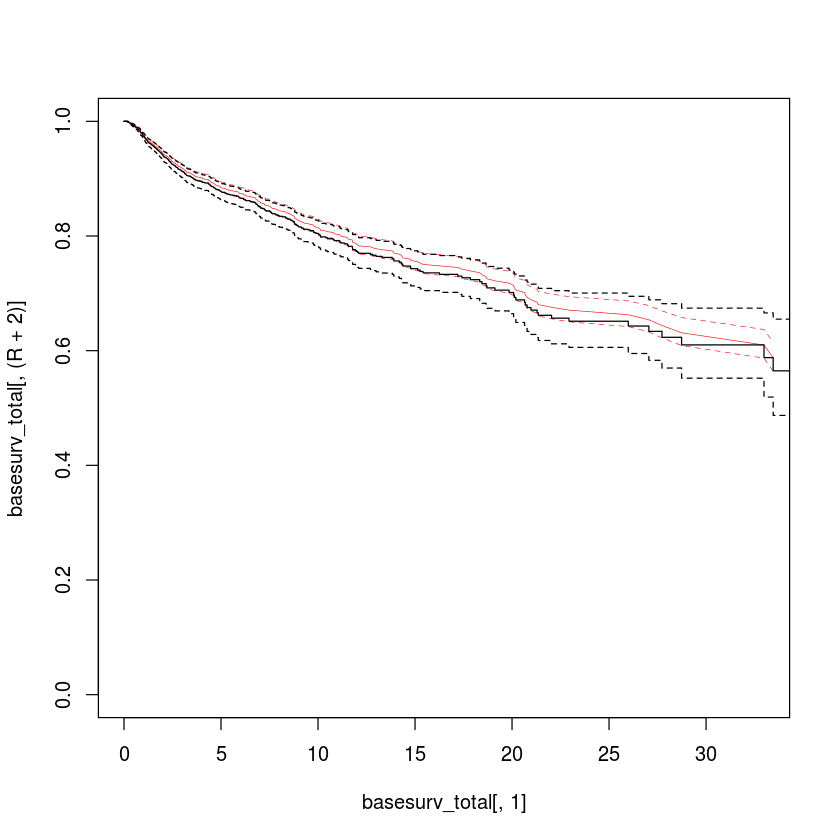

In [18]:
plot(basesurv_total[,1], basesurv_total[,(R+2)], type="l", col="red", lty=1, lwd=0.5, xlim=c(0,32.9868), ylim=c(0,1))
lines(basesurv_total[,1], basesurv_total[,(R+3)], type="l", col="red", lty=2, lwd=0.5)
lines(basesurv_total[,1], basesurv_total[,(R+4)], type="l", col="red",lty=2,  lwd=0.5)
lines(surv_central, col="black")

In [21]:
write.csv(basesurv_total, "/home/jiae/eicu-crd_0731/cox_eICU_H10_jupy/output/feature8_VARwt_basesurv_total.csv")

In [19]:
summary(surv_central)

Call: survfit(formula = central_fit, newdata = c(x1 = 59.91168, x2 = 9.810997, 
    x3 = 36.20453, x4 = 7.34948, x5 = 41.04722, x6 = 31.10893, 
    x7 = 1.509144, x8 = 59.0167), conf.int = 0.95)

   time n.risk n.event survival  std.err lower 95% CI upper 95% CI
  0.172   2910       1    1.000 0.000208        0.999        1.000
  0.188   2908       1    1.000 0.000295        0.999        1.000
  0.194   2907       1    0.999 0.000362        0.999        1.000
  0.206   2906       2    0.999 0.000470        0.998        1.000
  0.226   2904       1    0.999 0.000516        0.998        1.000
  0.234   2903       1    0.999 0.000558        0.997        1.000
  0.237   2902       1    0.998 0.000598        0.997        0.999
  0.243   2900       1    0.998 0.000635        0.997        0.999
  0.249   2898       1    0.998 0.000671        0.997        0.999
  0.258   2897       1    0.998 0.000704        0.996        0.999
  0.276   2896       1    0.997 0.000737        0.996        0.999


In [20]:
central_fit

Call:
coxph(formula = Surv(time, Y) ~ x1 + x2 + x3 + x4 + x5 + x6 + 
    x7 + x8, data = central, ties = "breslow")

        coef exp(coef)  se(coef)       z        p
x1  0.015121  1.015236  0.002969   5.093 3.52e-07
x2 -0.090159  0.913786  0.011202  -8.048 8.39e-16
x3 -0.146756  0.863505  0.024878  -5.899 3.66e-09
x4 -4.274761  0.013915  0.385733 -11.082  < 2e-16
x5 -0.021926  0.978313  0.004215  -5.202 1.97e-07
x6  0.006145  1.006164  0.001653   3.717 0.000202
x7  0.027441  1.027821  0.007894   3.476 0.000508
x8  0.008739  1.008778  0.001819   4.805 1.55e-06

Likelihood ratio test=458.7  on 8 df, p=< 2.2e-16
n= 2910, number of events= 541 

In [32]:
sqrt(var(loss_WIM_para_VAR[,2]))
0.011202*0.011202

[1] 0.009896964

[1] 0.0001254848

In [38]:
cov(loss_WIM_para_VAR)
cov(sort(loss_WIM_para_VAR[,1]),sort(loss_WIM_para_VAR[,2]))


7.749898e-06,-1.771658e-06,-9.192669e-06,-1.762584e-04,1.067780e-06,-1.153376e-06,4.106501e-06,8.267625e-08
-1.771658e-06,9.794989e-05,-2.646069e-05,8.941453e-06,-4.750396e-06,-7.672883e-07,-7.857442e-06,3.032005e-06
-9.192669e-06,-2.646069e-05,7.927189e-04,-1.140011e-03,-2.182460e-05,1.794897e-06,-1.238805e-05,-2.702767e-06
-1.762584e-04,8.941453e-06,-1.140011e-03,1.125031e-01,-5.374137e-06,1.130561e-04,-1.537557e-05,1.768365e-04
1.067780e-06,-4.750396e-06,-2.182460e-05,-5.374137e-06,1.557847e-05,1.222890e-07,7.981997e-06,-1.203870e-06
-1.153376e-06,-7.672883e-07,1.794897e-06,1.130561e-04,1.222890e-07,2.226602e-06,-3.073630e-06,3.366008e-07
4.106501e-06,-7.857442e-06,-1.238805e-05,-1.537557e-05,7.981997e-06,-3.073630e-06,7.031972e-05,8.162639e-07
8.267625e-08,3.032005e-06,-2.702767e-06,1.768365e-04,-1.203870e-06,3.366008e-07,8.162639e-07,2.258324e-06


[1] 2.739681e-05

In [30]:
vcov(central_fit)

,x1,x2,x3,x4,x5,x6,x7,x8
x1,8.814888e-06,-3.449904e-06,6.377339e-06,-0.0001176645,-6.532754e-07,-1.060609e-06,5.256044e-06,-1.694268e-07
x2,-3.449904e-06,1.254864e-04,-4.857639e-05,-0.0002233723,-9.239396e-07,-1.063909e-06,-6.703078e-08,3.546922e-06
x3,6.377339e-06,-4.857639e-05,6.189212e-04,-0.0023727562,-1.342195e-05,-2.218907e-06,-2.678845e-06,1.719164e-06
x4,-1.176645e-04,-2.233723e-04,-2.372756e-03,0.1487896003,4.677273e-04,1.262261e-04,7.426730e-05,1.801261e-04
x5,-6.532754e-07,-9.239396e-07,-1.342195e-05,0.0004677273,1.776531e-05,3.069565e-07,2.480838e-06,-1.168392e-06
x6,-1.060609e-06,-1.063909e-06,-2.218907e-06,0.0001262261,3.069565e-07,2.733699e-06,-2.574805e-06,3.119906e-07
x7,5.256044e-06,-6.703078e-08,-2.678845e-06,0.0000742673,2.480838e-06,-2.574805e-06,6.230840e-05,-8.181275e-07
x8,-1.694268e-07,3.546922e-06,1.719164e-06,0.0001801261,-1.168392e-06,3.119906e-07,-8.181275e-07,3.308266e-06


In [35]:
cov(c(1,0,3), c(4,10,6))-++

[1] -2.333333

In [42]:
cov(c(0,3,1), c(4,10,6))

[1] 4.666667